<h1>Evolving the StarCraftII Build Order Meta with Neural Networks</h1>

<h2>Introduction</h2>
Google's Artificial Intelligence research group, [DeepMind](https://deepmind.com/) recently released a python API, [pySC2](https://github.com/deepmind/pysc2) for the popular Real Time Strategy (RTS) computer game, [StarCraftII](http://us.battle.net/sc2/en/). After successfully conquering the boardgame, Go, with their AlphaGo program, [DeepMind has set their sights](https://deepmind.com/blog/deepmind-and-blizzard-open-starcraft-ii-ai-research-environment/) on the next big challenge for AI systems in attempting to train these systems to learn how to compete with world champions in the increadibly complex world of StarCraft. In this post, we use the pySC2 API to collect gameplay data from replays of human played games with the aim of discoverying some macro elements of the game, such as the different technology progression trees players use. Ultimately, the hope is to build up some intuition on what data is availible from the pySC2 API and how it might be useful in building systems capable of playing the game, but that work will be outside the scope of this post. For now we aim to discover the order of technology and units built by human players, and how those build orders change depending on what players learn about the build order of their opponent.

<h3>StarCraftII</h3>
StarCrafII is a Real Time Strategy game where players compete against each other on a game map by building an army of units to defeat the opponents army of units and associated buildings. Players need to construct buildings from gathered resources that allow them to create new units and buildings that advance the technology of the player to build stronger units. Each player has many options for how they wish to advance their technology tree, made more complex by the existance of 3 races (Terran, Protoss and Zerg) a player can select from with each having unique units, buildings and technology advancements. Different technologies are better at defeating certain units of the opposing players, but each player can only see the technology advancement of their opponent by using units to search across the map to see what the oppenent is doing and to learn how best to adapt their technology advancement against what their opponent is building.

<h3>Dataset</h3>
The dataset was collected using the pySC2 API from replays released by Blizzard Entertainment for version 3.16.1 of the game. The data is only taken from replays of Platinum players (MMR > 3440) and only utilizes the feature layers exposed by the API. The final dataset contains over 25,000 replays, with half being from player1's persepective and the other half from player2's persepective of the same replay. The state of the game for each replay was taken every 1 second and saved into a state data list with the following elements at each index.

State Data:  
0: replay_id  
1: map_name  
2: player_id  
3: minimap - blank list []  
4: friendly_army - [unit_id,count]   
5: enemy_army  - [unit_id, count]  
6: player (resource data)  
7: availible_actions  
8: taken actions  
9: winner  
10: race  
11: enemy race

<h2>BuildRecommender Class</h2>
To perform the analysis, we have a helper class that abstracts away the data-munging and machine-learning tasks we'll be utilizing. The class became a bit of a behemoth and could probably use some refactoring, but it has everything we need to load up the data, transform it, train the RNN model and evolve its hyperparameters and finally make the build predictions we're after. The full class can be found in this analysis' [repository](https://github.com/cole-maclean/autocraft), but we'll highlight the more interesting bits throughout this notebook.

In [1]:
from BuildRecommender import BuildRecommender

<h2>Exploratory Data Analysis</h2>
Before jumping right into building a model, lets explore the build order data, building visualizations to view common builds and get a sense of the dataset.

<h3>Build Data</h3>
We can use the data loader to collect the build order data we have. The data has been parsed into a 6-tuple of [build_order,won,race,enemy_race,map,replay_id] where build order is a list of uniquely seen buildings and units in order of sighting by the players perspective. Builds/units are marked with a trailing 0 or 1 to indicate if the unit is the player's(0) or the opponent's(1). Won indicates whether the player won the match or not.

In [4]:
#parse, save and load build data
builder = BuildRecommender("replay_state_data",'build_orders.json')
#builder.save_all_build_orders()
all_builds = builder.load_all_build_orders()
print("%s replays collected" %(len(all_builds)))
#example build_data
all_builds[0]

25115 replays collected


[['Nexus0',
  'Probe0',
  'Pylon0',
  'Gateway0',
  'Assimilator0',
  'Hatchery1',
  'SpawningPool1',
  'Egg1',
  'Drone1',
  'Extractor1',
  'CyberneticsCore0',
  'Overlord1',
  'Stargate0',
  'Adept0',
  'AdeptPhaseShift0',
  'Zergling1',
  'Oracle0',
  'WarpGate0',
  'Queen1',
  'CreepTumor1',
  'Zealot0',
  'Larva1',
  'SporeCrawler1',
  'Sentry0',
  'TwilightCouncil0',
  'Forge0',
  'MothershipCore0',
  'Phoenix0',
  'RoboticsFacility0',
  'OracleStasisTrap0',
  'Overseer1',
  'TemplarArchive0',
  'Lair1',
  'PhotonCannon0',
  'Observer0',
  'WarpPrism0',
  'InfestationPit1',
  'HydraliskDen1',
  'ChangelingZealot1',
  'HighTemplar0',
  'Immortal0',
  'Hydralisk1',
  'Archon0',
  'WarpPrismPhasing0',
  'Mutalisk1',
  'Stalker0',
  'Baneling1',
  'EvolutionChamber1',
  'Spire1',
  'BanelingCocoon1',
  'BroodLord1',
  'CreepTumorBurrowed1',
  'Broodling1',
  'Corruptor1',
  'BroodLordCocoon1',
  'CreepTumorQueen1'],
 False,
 'Protoss',
 'Zerg',
 'Mech Depot LE',
 '0000e057beefc9b1e9

<h3>Races, Maps and Winrates</h3>
Here we can investigate some general game stats

In [3]:
import pandas as pd
#load up static state data into dataframe
df = pd.DataFrame([build[1:] for build in all_builds],columns=['Won',"Race","EnemyRace","Map","ReplayID"])
df.sort_values(by=['Race'],inplace=True,ascending=True)
df.head()

,Won,Race,EnemyRace,Map,ReplayID
0,False,Protoss,Zerg,Mech Depot LE,0000e057beefc9b1e9da959ed921b24b9f0a31c63fedb8...
17476,False,Protoss,Zerg,Acolyte LE,50fcf294b394bf3ef38b326c96b93baf02c8380674c063...
17489,True,Protoss,Terran,Catallena LE (Void),510f3e2b4eaa42cf19401f58758e6d31987320613c18d8...
17493,True,Protoss,Terran,Interloper LE,510f82cc95ed9687a51560a02784e115d8770b2baf18a3...
6525,True,Protoss,Protoss,Odyssey LE,1f4e6a24bfeba8a59e7e77edc75ec85711e20cdc669dbe...


In [4]:
%matplotlib inline
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
races = set(df['Race'])

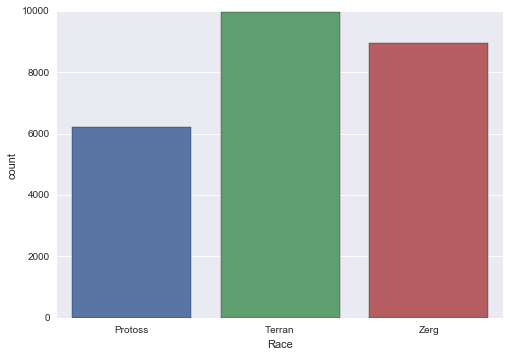

In [5]:
hue_order = ['Protoss','Terran','Zerg']
ax = sns.countplot(df['Race'])

Looks like Terran is the most popular race, followed closely by Zerg, but Protoss trailing quite heavily.  

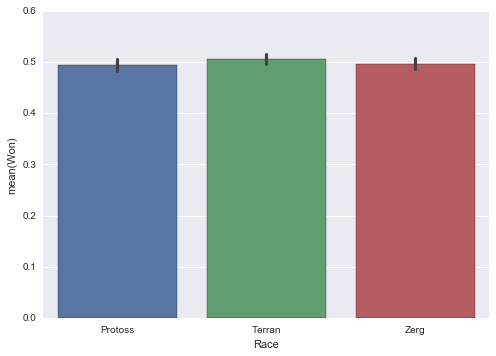

In [6]:
ax = sns.barplot(data=df,x='Race',y='Won')

All races are remarkably balanced in the dataset, with all having nearly exactly 50% winrates and all within the 95% confidence interval of the others.

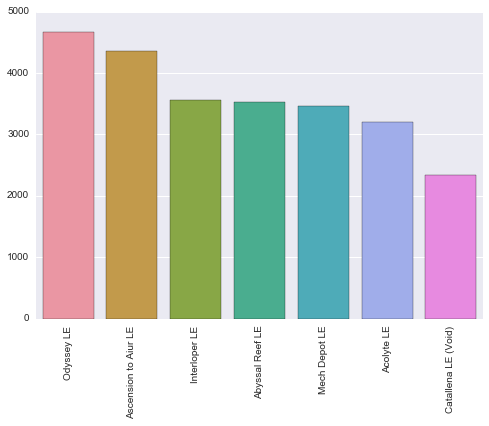

In [7]:
map_counts = df.groupby(by='Map').count()
labels,values = zip(*sorted(map_counts['Won'].items(), key=lambda x:x[1],reverse=True))

ax = sns.barplot(x=labels, y=values)
ax = ax.set_xticklabels(rotation=90,labels = labels)

That's a nice looking linearly decreasing trend in map popularity, with Odyssey being the favorite and Catallena way in last, but this is likely due to Catallena being the only 3 player ladder map, which can cause some extra quirks for players playing 1v1 on it.

In [8]:
map_race_counts = df.groupby(by=['Map','Race']).count()
mr_df = map_race_counts['Won'].reset_index()
maps = set(mr_df['Map'])

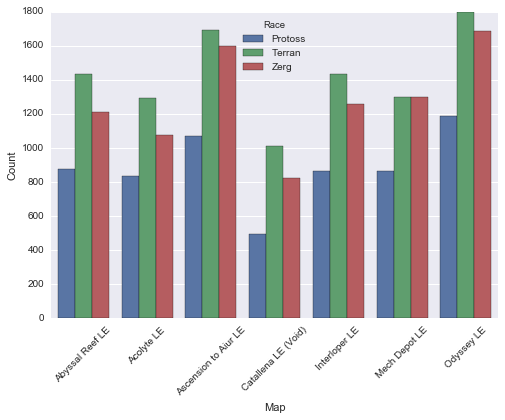

In [9]:
ax = sns.barplot(data=mr_df,x='Map', y='Won', hue='Race',hue_order=hue_order)
ax.set(xlabel='Map', ylabel='Count')
g = plt.xticks(rotation=45)

Protoss seem to especially dislike Catallena, prefering Odyssey and Ascension to Aiur. Terran and Zerg follow closely the general map popularity trend, with Terran favouring Odyssey the most. Terrans seem to be the race most willing to play Catallena. Lets check out the winrates for the races on each map.

In [10]:
map_race_win_counts = df.groupby(by=['Map','Race','Won']).count()
mrw_df = map_race_win_counts.reset_index()
mrw_df['Race_Won'] = mrw_df['Race'].astype(str) + mrw_df['Won'].astype(str)
mrw_df

,Map,Race,Won,EnemyRace,ReplayID,Race_Won
0,Abyssal Reef LE,Protoss,False,439,439,ProtossFalse
1,Abyssal Reef LE,Protoss,True,437,437,ProtossTrue
2,Abyssal Reef LE,Terran,False,709,709,TerranFalse
3,Abyssal Reef LE,Terran,True,727,727,TerranTrue
4,Abyssal Reef LE,Zerg,False,614,614,ZergFalse
5,Abyssal Reef LE,Zerg,True,595,595,ZergTrue
6,Acolyte LE,Protoss,False,418,418,ProtossFalse
7,Acolyte LE,Protoss,True,416,416,ProtossTrue
8,Acolyte LE,Terran,False,667,667,TerranFalse
9,Acolyte LE,Terran,True,625,625,TerranTrue


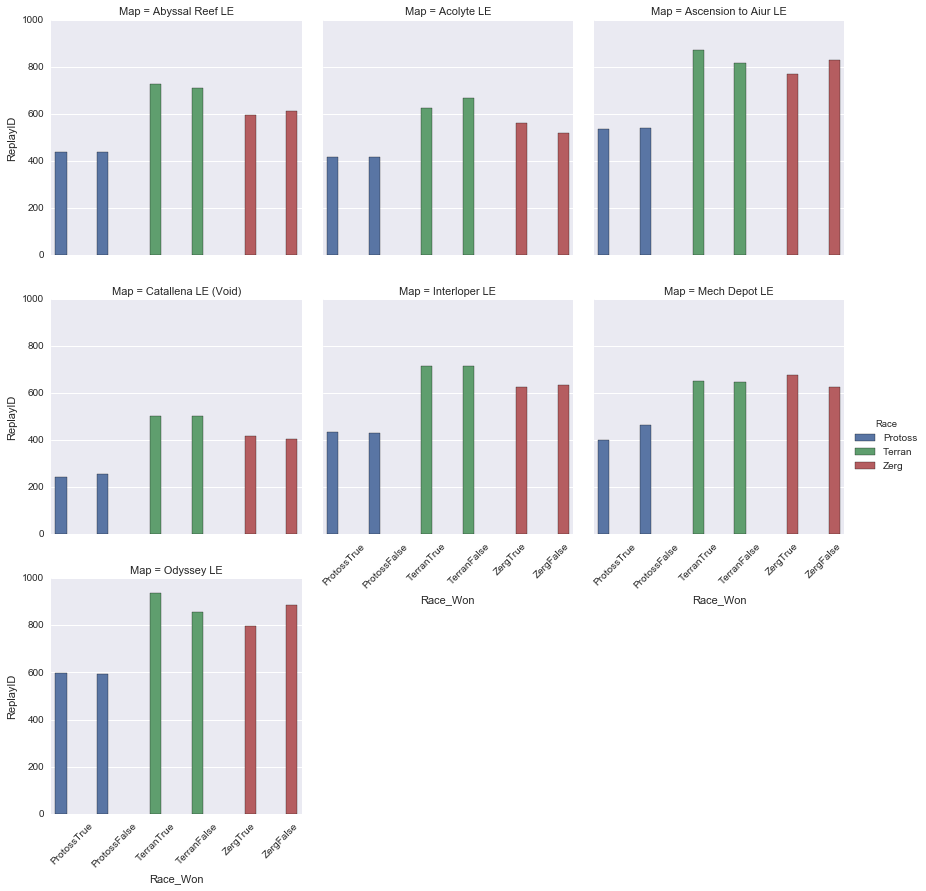

In [11]:
order = ['ProtossTrue','ProtossFalse', 'TerranTrue','TerranFalse', 'ZergTrue','ZergFalse']
fg = sns.factorplot(x='Race_Won', y='ReplayID', hue='Race', 
                        col='Map', data=mrw_df, kind='bar',
                   col_wrap=3,order=order,hue_order=hue_order)
for ax in fg.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

Most ladder maps are also quite balanced, with most races having equal wins and losses on each. The only imbalances that sitck out are Terran over Zerg on both Ascension to Auir and Odyssey and Zerg's slight advantage over Protoss on Mech Depot. Protoss is the only race that doesn't seem to have a subsantial edge on any map.  Here's a summary of the best and worst map for each race with winrates.

<b>Protoss</b>  
Best Map - Interloper (50.2%)  
Worst Map - Mech Depot (46.5%)  

<b>Terran</b>  
Best Map - Odyssey (52.3%)  
Worst Map - Acolyte (48.4%)  

<b>Zerg</b>  
Best Map - Mech Depot (52.0%)  
Worst Map - Odyssey (47.4%)

<h2>Build Orders and Winrates</h2>
Enough game meta, lets see what we can pull out from the build order data from the various replays

In [ ]:
tst_all = 

In [12]:
#grab only the firendly build order, filter out the enemies, keep won flag
all_friendly_builds = [[tuple([unit for unit in build[0] if unit[-1] == '0']),build[1]] for build in all_builds]
all_friendly_builds[0]

[('Nexus0',
  'Probe0',
  'Pylon0',
  'Gateway0',
  'Assimilator0',
  'CyberneticsCore0',
  'Stargate0',
  'Adept0',
  'AdeptPhaseShift0',
  'Oracle0',
  'WarpGate0',
  'Zealot0',
  'Sentry0',
  'TwilightCouncil0',
  'Forge0',
  'MothershipCore0',
  'Phoenix0',
  'RoboticsFacility0',
  'OracleStasisTrap0',
  'TemplarArchive0',
  'PhotonCannon0',
  'Observer0',
  'WarpPrism0',
  'HighTemplar0',
  'Immortal0',
  'Archon0',
  'WarpPrismPhasing0',
  'Stalker0'),
 False]

Max build length = 51
Average build length = 23


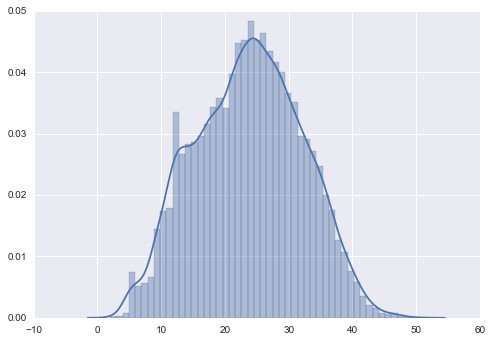

In [13]:
build_lengths = [len(bld[0]) for bld in all_friendly_builds]
max_build_len = max(build_lengths)
avg_build_len = np.mean(build_lengths)
print("Max build length = %s" %(max_build_len))
print("Average build length = %s" %int(avg_build_len))
g = sns.distplot(build_lengths,bins=50)

The length of a players build, ie the number of unique units in their tech tree, is a real nice normal distribution, with most games lasting between 20-30 unique buildings and units, tailing off into shorter and longer games up to a max of 51 unique units. There's a pretty big spike at the 12 unit mark, lets see if we can find what's causing that.

The script below can sort out the most common build orders at various stages of a game, and find the builds with the most wins.

In [2]:
from collections import Counter
def common_builds(all_builds,build_start,len_build,winner=None,n_top=10):
    #build win rate sorted if winner !=None, otherwise just sort by raw counts
    if winner != None:
        winning_rates = []
        #get winning and losing build counts to obtain build win rates
        winning_builds = Counter([build[0][build_start:min(len(build[0]),build_start + len_build +1)]
                  for build in all_builds
                  if build[1] == True])
        losing_builds = Counter([build[0][build_start:min(len(build[0]),build_start + len_build +1)]
                  for build in all_builds
                  if build[1] == False])
        for build in set(winning_builds).union(set(losing_builds)):
            if build in winning_builds:
                wins = winning_builds[build]
                
            else:
                wins = 0
            if build in losing_builds:
                loses = losing_builds[build]
            else:
                loses = 0
            win_rate = (wins/(wins+loses))
            winning_rates.append([build,win_rate,wins])
            #sort by build count and then win rate
        return sorted(winning_rates,key=lambda x:(x[2],x[1]),reverse=winner)[0:n_top]
    else:
        #sort by build counts only
        builds = Counter([build[0][build_start:min(len(build[0]),build_start + len_build +1)]
                  for build in all_builds])
        return builds.most_common(n_top)

Lets take a look at the spike at tech trees of length 12.

In [15]:
builds = Counter([tuple(build[0]) for build in all_friendly_builds if len(build[0]) == 12])
cmn_builds = builds.most_common(3)
for bld in cmn_builds:
    print(bld)
    print("")

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 120)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'BanelingNest0', 'Queen0', 'BanelingCocoon0', 'Baneling0'), 106)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'SpawningPool0', 'Extractor0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 43)



It looks like there's a spike at games ending once Zerg players get to Banelings. This might be due to Zergs typically all-ining at this point, or possibly this is when they're at their weakest state compared to their opponents at this stage (12 unit deep tech trees). Let's take a look at some other common builds.

In [16]:
cmn_builds = common_builds(all_friendly_builds,0,max_build_len,n_top=10)
for bld in cmn_builds:
    print(bld)
    print("")

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 120)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0'), 108)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'BanelingNest0', 'Queen0', 'BanelingCocoon0', 'Baneling0'), 106)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'SpawningPool0', 'Extractor0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 43)

(('Nexus0', 'Probe0', 'Pylon0', 'Forge0', 'PhotonCannon0'), 39)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'BanelingNest0', 'Zergling0', 'Queen0', 'BanelingCocoon0', 'Baneling0'), 31)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0', 'BanelingNest0'), 29)

(('Hatchery0', 'Drone0'

Interesting that Terrans only showup in 1 of the top 10 most common builds. Perhaps they have more variability in how they can start their games. We can checkout the most common early builds (ie first 6 units).

In [8]:
cmn_builds = common_builds(all_friendly_builds,0,10,n_top=10)
for bld in cmn_builds:
    print(bld)
    print("")

NameError: name 'all_friendly_builds' is not defined

Zergs seem to have the most deterministic beginning game tech tree expansion options being far and away the top two most common opening builds, followed by Protoss, and as suspected, Terrans have more varation to their starts. Lets see how win counts and rates affect the opening 6 unit build counts. 

In [18]:
cmn_builds = common_builds(all_friendly_builds,0,6,winner=True, n_top=10)
for bld in cmn_builds:
    print(bld)
    print("")

[('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0'), 0.4968334388853705, 3138]

[('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'SpawningPool0', 'Extractor0'), 0.49739039665970775, 953]

[('Nexus0', 'Probe0', 'Pylon0', 'Gateway0', 'Assimilator0', 'CyberneticsCore0', 'MothershipCore0'), 0.47572815533980584, 490]

[('Nexus0', 'Probe0', 'Pylon0', 'Gateway0', 'Assimilator0', 'CyberneticsCore0', 'Stargate0'), 0.48897795591182364, 488]

[('Nexus0', 'Probe0', 'Pylon0', 'Gateway0', 'Assimilator0', 'CyberneticsCore0', 'Zealot0'), 0.4819277108433735, 360]

[('CommandCenter0', 'SCV0', 'SupplyDepot0', 'Refinery0', 'Barracks0', 'SupplyDepotLowered0', 'Factory0'), 0.5229357798165137, 342]

[('CommandCenter0', 'SCV0', 'SupplyDepot0', 'Refinery0', 'Barracks0', 'Factory0', 'OrbitalCommand0'), 0.48783977110157367, 341]

[('Nexus0', 'Probe0', 'Pylon0', 'Gateway0', 'Assimilator0', 'CyberneticsCore0', 'Adept0'), 0.49319213313161875, 326]

[('CommandCenter0', 'SCV0

The Zerg openers have the highest number of wins due to the above mentioned limited options they have at the open, but their winrate is pretty similar to the other races typical openers at 50%. Terrans rushing to a Factory or OrbitalCommand seem to have the biggest edge in builds, but only with 52-53% winrates. These numbers will change depending on how you define how many units there are in the "opening" of the game (ie. 6? 7? 10?). The number of different permuations of build orders for each race becomes intractable at even small build counts. For example, assuming 3 availible expansion options at each stage in the tech tree, we could see up to 100 billion different build orders in the average build length of 23 units. Including the opponents potential builds into the order makes the numbers explode even more. There's no way we can collect enough replays to see every possible build, so we'll need to build a predictive model based on the data we do have. Below we build a RNN based sequence model in an attempt to learn patterns in our datasets build sequences to generalize to likely other build sequences we might like to investigate. With this model we can also predict the most likely next technology steps our opponent might make at any stage in a game of StarCraftII. 

<h2>Build Order Sequence Predictor</h2>

Here we'll train an RNN model using the [tflearn](http://tflearn.org/) API for tensorflow, with some added sauce to get the most out of our model. We'll use the [Dask](https://dask.pydata.org/en/latest/) framework to build some out-of-memory numpy arrays, we'll incorporate early stopping so we back out of training once our model starts to overfit (validation score begins increasing), and we're going to use a parallelized Genetic Algorithm to evolve some of the hyperparameters of our model using the [DEAP](https://github.com/DEAP/deap) python library. The code implementing these parts are self contained in the BuildRecommender class, but we'll highlight some snippets and gotchyas here.

<h3>Early Stopping</h3>
Below is the EarlyStoppingCallback class we've adapted from the tutorial [here](http://mckinziebrandon.me/TensorflowNotebooks/2016/11/20/early-stopping.html). It allows us to define a condition at the end of each epoch we can check to end training. For our implementation, we stop training if the current epochs validation loss is larger than the best epochs training loss by more than max_val_loss_delta percent.

<b>Gotchyas</b>  
One gotchya that took a bit to figure out was returning the trained model to the program to continue training other models because the early stopping class wasn't returning anything. I ended up wrapping the tflearn training line in a StopIteration error handle to return the model when early stopping was thrown.  

In [ ]:
'''Training early stopping error handling snippet'''
# Training
early_stopping_cb = EarlyStoppingCallback(max_val_loss_delta=0.01)
#Need to catch early stopping to return model
try:
    model.fit(self.trainX, self.trainY, validation_set=(self.testX, self.testY), show_metric=False,snapshot_epoch=True,
              batch_size=128,n_epoch=self.epochs,run_id="%s-%s-%s-%s" %(arch,n_units,dropout,learning_rate),
              callbacks=early_stopping_cb)
    return model
except StopIteration:
    return model

class EarlyStoppingCallback(tflearn.callbacks.Callback):
    """
    Early stopping class to exit training when validation loss begins increasing
    """
    def __init__(self, max_val_loss_delta):
        """
        best_val_loss - stores the best epochs validation loss for current val loss compariason
                        to check if increasing. Initizalized at -inf
        max_val_loss_delta - the maximum percent the current val loss can be above the best_val_loss 
                             without exiting training
        """ 
        self.best_val_loss = math.inf
        self.max_val_loss_delta = max_val_loss_delta
    
    def on_epoch_end(self, training_state):
        """ 
        This is the final method called in trainer.py in the epoch loop. 
        We can stop training and leave without losing any information with a simple exception.
        On epoch end, check if validation loss has increased by more than max_val_loss_delta, if True,
        exit training  
        """
        #check if current loss better than previous best and store
        self.best_val_loss = min(training_state.val_loss,self.best_val_loss)
        if (training_state.val_loss - self.best_val_loss) >= self.best_val_loss*self.max_val_loss_delta:
            print("Terminating training at the end of epoch", training_state.epoch)
            print("Epoch loss = %s vs best loss = %s" %(training_state.val_loss, self.best_val_loss))
            raise StopIteration      
    
    def on_train_end(self, training_state):
        """
        Furthermore, tflearn will then immediately call this method after we terminate training, 
        (or when training ends regardless). This would be a good time to store any additional 
        information that tflearn doesn't store already.
        """
        print("Successfully left training! Final model loss:", training_state.val_loss)

<h3>Model Definition</h3>
Below is the model definition and training scripts used to train the network. It takes as input some hyperparameters of the model (which could come from an evolution process...), builds the network definition using tflearns API and initiates the model fitting on the data.

In [ ]:
def train(self, hyperparams):
        #reset graph from previously trained iterations
        tf.reset_default_graph()
        if self.X == []:
            self.make_training_data()
        
        self.trainX, self.testX, self.trainY, self.testY = self.preprocessing(self.X,self.y)    

        # Hyperparameters
        arch,n_units,dropout,learning_rate = hyperparams

        # Network building
        net = tflearn.input_data([None, self.max_seq_len])
        net = tflearn.embedding(net, input_dim=len(self.vocab), output_dim=128,trainable=True)

        if arch == 0:
            net = tflearn.lstm(net, n_units=n_units,
                               dropout=dropout,
                               weights_init=tflearn.initializations.xavier(),return_seq=False)
        else:
            net = tflearn.gru(net, n_units=n_units,
                              dropout=dropout,
                              weights_init=tflearn.initializations.xavier(),return_seq=False)
        net = tflearn.fully_connected(net, len(self.vocab), activation='softmax',
                                      weights_init=tflearn.initializations.xavier())
        net = tflearn.regression(net, optimizer='adam', learning_rate=learning_rate,
                                 loss='categorical_crossentropy')
        model = tflearn.DNN(net, tensorboard_verbose=2,
                            tensorboard_dir='C:/Users/macle/Desktop/Open Source Projects/autocraft/EDA/tensorboard')       

        # Training
        early_stopping_cb = EarlyStoppingCallback(max_val_loss_delta=0.01)
        #Need to catch early stopping to return model
        try:
            model.fit(self.trainX, self.trainY, validation_set=(self.testX, self.testY), show_metric=False,snapshot_epoch=True,
                      batch_size=128,n_epoch=self.epochs,run_id="%s-%s-%s-%s" %(arch,n_units,dropout,learning_rate),
                      callbacks=early_stopping_cb)
            return model
        except StopIteration:
            return model

<h3>Hyperparameter Evolution</h3>
Below is the hyperparameter's evolve function, which was modified only slightly from the DEAP overview tutorial [here](https://deap.readthedocs.io/en/master/overview.html) We're going to evolve 4 hyperparameters of the model - The RNN cell architecture (LSTM or GRU), the number of units in the recurrent layer, the dropout and the learning rate.

<b>Gotchyas</b>  
In order to run on multiple processors, the DEAP framework requires the evolve creator object and evolve function to be in the global scope of the main script, so these are not methods of the BuildRecommender class, they are seperate and in the global scope of the script.

In [ ]:
#DEAP creator definition needs to be in global scope to parallelize
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#Individual represented as list of 4 floats 
#(arch,n_units,dropout,learning_rate)
#arch is the cell architecture 0 = lstm, 1 = gru
#floats are later decoded to appropriate sizes
#for each hyperparamter
IND_SIZE=4
creator.create("Individual", list, fitness=creator.FitnessMax)

def evolve(builder,n_pop,co_prob,mut_prob,n_generations):
        '''Evolve the models hyperarameters (arch,n_units,dropout,learning_rate)'''

        toolbox = base.Toolbox()
        #Setup fitness (maximize val_loss)
        toolbox.register("attr_float", random.random)
        toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_float, n=IND_SIZE)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        toolbox.register("evaluate", builder.evaluate)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        #assign the number of processors to run parallel fitness evaluations on
        pool = multiprocessing.Pool(16)
        toolbox.register("map", pool.map)

        pop = toolbox.population(n=n_pop)
        best_ind = pop[0]
        best_fit = -math.inf

        # Evaluate the entire population
        fitnesses = list(toolbox.map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            print("Evaluating %s" %ind)
            ind.fitness.values = fit

        for g in range(n_generations):
            print("Running generation %s" %(g))
            # Select the next generation individuals
            offspring = toolbox.select(pop, len(pop))
            # Clone the selected individuals
            offspring = list(map(toolbox.clone, offspring))

            # Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < co_prob:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < mut_prob:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = list(toolbox.map(toolbox.evaluate, pop))
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
                #keep the single best perfoming ind through all gens
                if fit[0] > best_fit:
                    best_ind = ind
                    best_fit = fit[0]

            # The population is entirely replaced by the offspring
            pop[:] = offspring
        return best_ind

The above evolution process was used for 5 generations of 16 individuals on an AWS instance with only 5% of the data to identify the best individual hyperparameters, which ended up being: [1,333,0.65,0.0055]. We'll use these hyperparameters to train a final model on the total dataset. Extending the hyperparameter evolution from 5% of the dataset to the whole thing is a big assumption, and the model would likely perform better if we evolved the hyperparameters on the full data, but for the sake of time we'll use the smaller evolved hyperparameters as a proxy for the final model's. It turned out that the learning rate for the evolved network was to large, so we've added an extra 0 to it to train on the full dataset.

In [6]:
builder = BuildRecommender("replay_state_data",'build_orders.json',
                           down_sample=1)
builder.model = builder.train(hyperparams=[1,333,0.65,0.00055])

Training Step: 32009  | total loss: 2.67556 | time: 6093.463s
| Adam | epoch: 005 | loss: 2.67556 -- iter: 819328/819441
Training Step: 32010  | total loss: 2.64712 | time: 6358.537s
| Adam | epoch: 005 | loss: 2.64712 | val_loss: 2.51044 -- iter: 819441/819441
--
Successfully left training! Final model loss: 2.51044451435


In [7]:
model_score = builder.model.evaluate(builder.testX, builder.testY)[0]
model_score

c:\python35\lib\site-packages\dask\core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


0.35719829542609255

The model only trains for 5 epochs on the full dataset, so there might be potential to squeek out even better performance with smaller learning rates, but the performance of this model is actually already impressive, getting 36% of the predicted next unit exactly correct. Using some further heuristics like only predicting units that exist in the race of the player we're predicting for should increase this number even further.

<h2>Using the Model</h2>
Now that we have a trained model capable of predicting the sequence of builds in StarCraftII, we can use it to make predictions of how games will develop starting from arbitrary initial builds. Lets first check the most common build we discovered above - zerg rush to Banelings. We'll input the sequence of builds leading up to banelings and hopefully our model will predict correctly.

In [12]:
builder.load_graph()
rec_build = builder.predict_build(['Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0',
                                   'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0',
                                   'BanelingNest0', 'BanelingCocoon0'],1,races=['Zerg0','Terran1'])
rec_build

['Baneling0']

Nailed it! Looks like, at the very least, our model has discovered the most common build. Lets see how each race starts look.

In [13]:
builder.predict_build(['CommandCenter0'],6,races=['Terran0','Zerg1'])

['SCV0',
 'SupplyDepot0',
 'Refinery0',
 'Barracks0',
 'SupplyDepotLowered0',
 'Factory0']

In [14]:
builder.predict_build(['Hatchery0'],6,races=['Zerg0','Protoss1'])

['Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0']

In [17]:
builder.predict_build(['Nexus0'],6,races=['Protoss0','Zerg1'])

['Probe0', 'Pylon0', 'Gateway0', 'Assimilator0', 'CyberneticsCore0', 'Zealot0']

Those builds seem pretty sensible to me, looks like our model has correctly captured how each race normally expands their tech tree. The text interface we're using here isn't very user friendly, so we'll build a super simple visualization and webapp so people can play with the model and make their own builds.

<h2>Webapp</h2>
Using the final model built above, I threw together a simple webapp so users can discover and visualize their own custom StarCraftII build orders. The webapp can be played with [here](http://ponderinghydrogen.pythonanywhere.com/sc2). Note that the app makes an single inference from the model for each unit added to the build order, so large build orders can take a looong time to process.

![webapp](webapp.png)

<h2>Conclusions</h2>
There were three main goals of this project:
1. Build familiarity with the pySC2 API and data
2. Develop a StarCraftII build order predictive model  
3. Learn and test the applications of Genetic Algorithms to neural network hyperparameter optimization

Another final goal was to have fun with it! I think I accomplished all of those goals, and am pretty impressed by the deep learning scaffolding I've built-up: from data-munging and representation to model definitions and now hyperparameter evolutions. I think next steps will be to bring these skills into a Reinforcement Learning (RL) project and see if I can start training a StarCraftII bot to play the game!

<h2>Limitations and Future Work</h2>
<b>Unique Unit Builds and Upgrades</b>  
The build orders in this project are only unique units/tech tree expansions seen as the game progresses, where in reality the number of buildings/units you create is very important (ie. 2/3 Barracks' built in the early game). Another missing component in the tech stack is researched capabilities and upgrades a player can build to boost their units strength. To get a more accurate representation of the StarCraftII's build order meta, these components will need to be included.

<b>Hyperparameter Evolving</b>  
There are many other hyperparameters in the model that could be evolved like activation functions (aside: There's an interesting conversation happening on [r/MachineLearning](https://www.reddit.com/r/MachineLearning/comments/773epu/r_swish_a_selfgated_activation_function_google/) about these right now), the number of layers, embedding dimensions etc. Our evolutionary method actually has more hyperparameters to tune then the ones we're actually tuning! (ie. crossover, muatation rates and all the other turtles). We also only allowed the evolution process to continue for 5 generations, which may not be enough to discover really good hyperparameter combinations, but I still prefer this over grid/random search methods. To really get the most out of this approach, we should probably tune our hyperparameters using the full dataset and let the process run for a longer period, plus adding in more of the hyperparameters of the model.

<b>Optimal Build Order</b>  
Although our model is capable of capturing the likely build orders of Platinum and above players, it doesn't actually incorporate winrates or a concept of optimality in the builds. This project could be extended to an RL setting where a model could be trained capable of learning an optimal policy and a learned value function that estimates the probability of winning given the current state of the game. This problem would likely be a good use case for Actor-Critic methods that learn policy and value functions together, such as the one Google is seeing substantial successes in with [AlphaGo.](https://deepmind.com/blog/alphago-zero-learning-scratch/)

<b>The Changing Meta</b>  
Updates to StarCraftII are continually being made to add new content and balance units. This causes the advantages of units and build orders to change over time as the game evolves. The method developed in this post could be extended to predict the impact game changes might have on build metas and potentially identify new, successful builds before opponents do to give players an extra edge in the game.